## Shell Contact Example

In [1]:
# !pip install debugpy

In [2]:
import numpy as np

import dismech


geom = dismech.GeomParams(rod_r0=0.005,
                          shell_h=0.005)

material = dismech.Material(density=1200,
                            youngs_rod=0,
                            youngs_shell=2e10,
                            poisson_rod=0,
                            poisson_shell=0.5)

shell_contact_sim = dismech.SimParams(static_sim=False,
                                  two_d_sim=False,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-3,
                                  max_iter=100,
                                  total_time=1,
                                  plot_step=1,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
# env.add_force('gravity', g=np.array([0.0, 0.0, 0]))
env.add_force('damping', eta = 50)
# # env.add_force('aerodynamics', rho=1000, cd=1)
env.add_force('hydrodynamics', rho=1000, cd=0.2)
env.add_force('thrust', thrust_coeff = 1000)

# env.add_force('selfContact', delta=0.01*2*5e-3, h=5e-3)
# env.set_static()  

geo = dismech.Geometry.from_txt('input hemisphere more dense.txt')
# geo = dismech.Geometry.from_txt('input hemisphere most dense.txt')

robot = dismech.SoftRobot(geom, material, geo, shell_contact_sim, env)

In [3]:
log_node = np.array(np.where(
    robot.state.q[robot.node_dof_indices].reshape(-1, 3)[:, 2] >= 0.999)[0])

In [4]:
print("# nodes: ", np.shape(robot.nodes))
print("# faces: ", np.shape(robot.face_nodes_shell))

# nodes:  (105, 3)
# faces:  (176, 3)


### Time Stepping

As we are performing a static simulation, we must change gravity for each time step.

In [5]:
stepper = dismech.ImplicitEulerTimeStepper(robot)

In [6]:
# # actuate only tangential hinges
# from scipy.signal import sawtooth

# def actuate_jellyfish(robot, t):
#     pulse_freq = 1.5            # Hz
#     pulse_amplitude = np.pi/2     # radians
#     theta_rest = 0.0

#     T = 1.0 / pulse_freq
#     s = 0.5 * (1 - sawtooth(2 * np.pi * t / T, width=0.3))  # asymmetric cycle
#     theta_base = theta_rest - pulse_amplitude * s

#     n_hinges = robot.hinge_springs.inc_strain.shape[0]
#     theta_bars = np.zeros(n_hinges)

#     apex_z = np.max(robot.state.q[:robot.end_node_dof_index].reshape(-1, 3)[:, 2]) # max height of the apex
#     xy_coords = robot.state.q[:robot.end_node_dof_index].reshape(-1, 3)[:, :2]
#     radii = np.linalg.norm(xy_coords, axis=1)
#     base_radius = np.max(radii)

#     for i in range(n_hinges):
#         n1, n2 = robot.hinge_springs.nodes_ind[i, 0:2]
#         p1 = robot.state.q[robot.map_node_to_dof(n1)]
#         p2 = robot.state.q[robot.map_node_to_dof(n2)]
#         midpoint = 0.5 * (p1 + p2)

#         r_vec = midpoint[:2]  # radial vector (XY plane)
#         r_norm = np.linalg.norm(r_vec)
#         if r_norm == 0:
#             continue  # skip apex hinges

#         hinge_vec = p2 - p1
#         hinge_vec_xy = hinge_vec[:2]
#         hinge_norm = np.linalg.norm(hinge_vec_xy)
#         if hinge_norm == 0:
#             continue  # degenerate hinge

#         # Normalize
#         r_dir = r_vec / r_norm
#         hinge_dir = hinge_vec_xy / hinge_norm

#         # Compute alignment (dot product → |cosθ|)
#         alignment = np.abs(np.dot(r_dir, hinge_dir))

#         # We want hinges close to perpendicular → apply filter or weighting
#         tangential_weight = 1 - alignment  # max at perpendicular, min at aligned

#         z = midpoint[2] / apex_z  # normalized height
#         phase_delay = 0.1 * z

#         theta = theta_rest - pulse_amplitude * 0.5 * (1 - sawtooth(2 * np.pi * (t - phase_delay) / T, width=0.3))

#         # Scaling actuation by radial position (smoothstep) and tangential weight
#         scale_r = 3 * (r_norm / base_radius)**2 - 2 * (r_norm / base_radius)**3
#         scale = scale_r * tangential_weight

#         theta_bars[i] = theta * scale

#     robot.hinge_springs.inc_strain = theta_bars
#     return robot
# stepper.before_step = actuate_jellyfish

In [7]:
from scipy.signal import sawtooth

def actuate_jellyfish(robot, t):
    pulse_freq = 4            # Hz
    pulse_amplitude = 4*np.pi/5    # radians
    theta_rest = 0.0

    T = 1.0 / pulse_freq
    s = 0.5 * (1 - sawtooth(2 * np.pi * t / T, width=0.3))  # asymmetric cycle
    theta_base = theta_rest - pulse_amplitude * s

    n_hinges = robot.hinge_springs.inc_strain.shape[0]
    theta_bars = np.zeros(n_hinges)

    apex_z = np.max(robot.state.q[:robot.end_node_dof_index].reshape(-1, 3)[:, 2]) # max height of the apex
    xy_coords = robot.state.q[:robot.end_node_dof_index].reshape(-1, 3)[:, :2]
    radii = np.linalg.norm(xy_coords, axis=1)
    base_radius = np.max(radii)

    for i in range(n_hinges):
        n1, n2 = robot.hinge_springs.nodes_ind[i, 0:2]
        p1 = robot.state.q[robot.map_node_to_dof(n1)]
        p2 = robot.state.q[robot.map_node_to_dof(n2)]
        midpoint = 0.5 * (p1 + p2)

        r = np.linalg.norm(midpoint[:2]) / base_radius  # normalized radial distance
        z = midpoint[2] / apex_z                        # normalized height

        # Optional: add a temporal traveling wave (e.g. delay based on z)
        phase_delay = 0.1 * z  # tweak this coefficient as needed
        theta = theta_rest - pulse_amplitude * 0.5 * (1 - sawtooth(2 * np.pi * (t - phase_delay) / T, width=0.3))

        # Scaling actuation by radial position (smoothstep)
        scale = 3 * r**2 - 2 * r**3

        theta_bars[i] = theta * scale

    robot.hinge_springs.inc_strain = theta_bars
    return robot

stepper.before_step = actuate_jellyfish

In [8]:
print(robot.hinge_springs.inc_strain.shape)

(248,)


In [9]:
robots = stepper.simulate()

qs = np.stack([robot.state.q for robot in robots])

13201.310065251733
983.3672532802283
current_time:  0.001
3107.9872656557054
117.13682119358094
current_time:  0.002
338.29245337707863
dV/dt: -0.00306, Total thrust: [0.         0.         3.06129255]
2.028646082224091
current_time:  0.003
509.3402491073299
dV/dt: -0.03012, Total thrust: [ 0.          0.         30.11804587]
5.432598853475212
current_time:  0.004
138.20868763938117
dV/dt: -0.00564, Total thrust: [0.         0.         5.64286782]
4.900840787985137
current_time:  0.005
dV/dt: -0.00000, Total thrust: [0.0000000e+00 0.0000000e+00 4.4408921e-10]
163.88722422021766
7.620862889679814
current_time:  0.006
169.62176734994833
11.814504691859423
current_time:  0.007
162.1835527373096
17.951542015320225
current_time:  0.008
174.7140047585211
27.233804955408132
current_time:  0.009000000000000001
dV/dt: -0.00000, Total thrust: [0.00000000e+00 0.00000000e+00 2.22044605e-10]
199.4660843528921
41.317092446839034
current_time:  0.01
232.69066035892112
63.17803395743738
current_time: 

[[ 6.49267132e-04  1.63729985e-04  9.99754493e-01]
 [ 6.49270570e-04  1.63731293e-04  9.99667641e-01]
 [ 6.49268790e-04  1.63733592e-04  9.99676796e-01]
 ...
 [-2.00449169e-03 -1.16807057e-03  1.23464232e+00]
 [-2.01538634e-03 -1.17360095e-03  1.23492489e+00]
 [-2.02636037e-03 -1.17928576e-03  1.23522085e+00]]


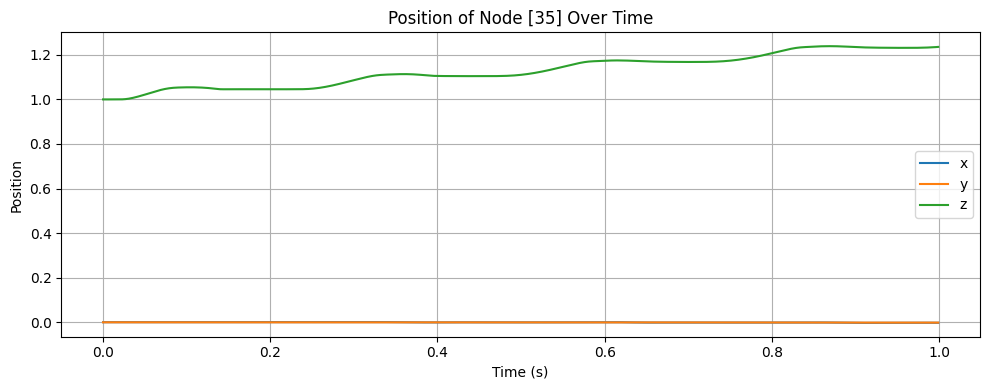

In [10]:
import matplotlib.pyplot as plt

# Extract the DOF indices (x, y, z) of the node you want to track
log_node_dofs = robot.map_node_to_dof(log_node)  # e.g., [ix, iy, iz]

# Extract position of that node across all timesteps
logged = qs[:, log_node_dofs].squeeze()  # shape (n_timesteps, 3)

# Plot x, y, z over time
t = np.arange(qs.shape[0]) * robot.sim_params.dt

print(logged)

plt.figure(figsize=(10, 4))
plt.plot(t, logged[:, 0], label='x')
plt.plot(t, logged[:, 1], label='y')
plt.plot(t, logged[:, 2], label='z')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.title(f'Position of Node {log_node} Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
t = np.arange(robot.sim_params.total_time, step=robot.sim_params.dt)
options = dismech.AnimationOptions(title='Shell contact p2p', plot_step=10)

fig = dismech.get_interactive_animation_plotly(robot, t, qs, options)
fig.show()

101


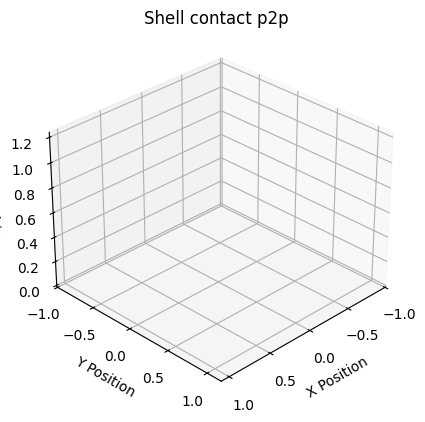

In [12]:
ani = dismech.get_animation(robot, t, qs, options)
ani.save('jellyfish.gif')